<a href="https://colab.research.google.com/github/savitskaya-om/python/blob/main/GAZP_price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/savitskaya-om/python

Cloning into 'python'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 68 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [227]:
df = pd.read_csv('python/GAZP_210801_220806.txt')

In [228]:
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,20210802,0,287.88,289.48,285.21,286.75,38297270
1,GAZP,D,20210803,0,286.77,288.05,284.34,287.09,27065240
2,GAZP,D,20210804,0,287.89,288.80,286.00,287.94,23599750
3,GAZP,D,20210805,0,287.31,288.28,285.16,285.95,47254880
4,GAZP,D,20210806,0,285.26,285.72,277.87,282.27,90600850


In [229]:
df = df[['<DATE>','<CLOSE>']]
df.columns = ["date", "close"]
df["date"] = pd.to_datetime(df['date'].astype(str), format = "%Y/%m/%d").values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [230]:
df.head()

,date,close
0,2021-08-02,286.75
1,2021-08-03,287.09
2,2021-08-04,287.94
3,2021-08-05,285.95
4,2021-08-06,282.27


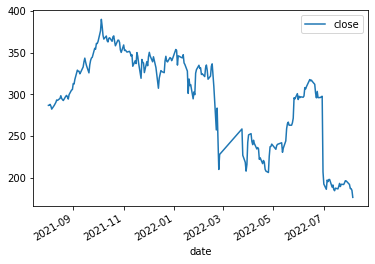

In [231]:
df.set_index("date").plot()

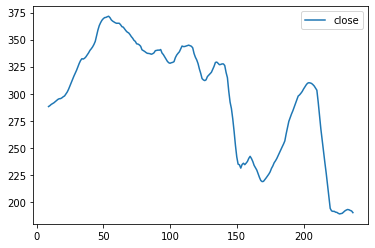

In [232]:
df.rolling(10).mean().plot()

In [233]:
# функция по созданию сгенерированных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.isin([5,6])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['close'].shift(lag)

    data['close_mean'] = data['close'].shift().rolling(rolling_mean_size).mean().copy()

In [234]:
df = df.set_index("date")
make_features(df, 7, 3)

In [245]:
df.head()

,close,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,close_mean
date,,,,,,,,,,,,,,
2021-08-02,286.75,2021,8,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-03,287.09,2021,8,3,1,0,286.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-04,287.94,2021,8,4,2,0,287.09,286.75,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-05,285.95,2021,8,5,3,0,287.94,287.09,286.75,NaN,NaN,NaN,NaN,287.260000
2021-08-06,282.27,2021,8,6,4,0,285.95,287.94,287.09,286.75,NaN,NaN,NaN,286.993333


In [246]:
df.dropna(inplace=True)
df.head()

,close,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,close_mean
date,,,,,,,,,,,,,,
2021-08-11,290.35,2021,8,11,2,0,288.61,286.68,282.27,285.95,287.94,287.09,286.75,285.853333
2021-08-12,293.23,2021,8,12,3,0,290.35,288.61,286.68,282.27,285.95,287.94,287.09,288.546667
2021-08-13,292.70,2021,8,13,4,0,293.23,290.35,288.61,286.68,282.27,285.95,287.94,290.730000
2021-08-16,295.10,2021,8,16,0,0,292.70,293.23,290.35,288.61,286.68,282.27,285.95,292.093333
2021-08-17,298.32,2021,8,17,1,0,295.10,292.70,293.23,290.35,288.61,286.68,282.27,293.676667


In [247]:
features = df.drop(['close'],axis = 1)
target = df['close']
X_train,X_test,y_train, y_test = train_test_split(features,target, shuffle=False, test_size=0.2)

In [ ]:
#df.iloc[df.index <= datetime.strptime("2022/08/05", "%Y/%m/%d")]

In [268]:
model = LinearRegression().fit(X_train, y_train)

In [270]:
# summarize feature importance
coefficients = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
coefficients.columns = ["feature", "coef"]
coefficients.sort_values(by = "coef",ascending=False)

,feature,coef
5,lag_1,7.055017e-01
12,close_mean,2.295346e-01
9,lag_5,1.692020e-01
6,lag_2,1.526713e-01
10,lag_6,2.290878e-02
2,day,1.456120e-02
4,is_weekend,-2.747802e-14
8,lag_4,-2.630198e-02
1,month,-8.772898e-02
11,lag_7,-1.467910e-01


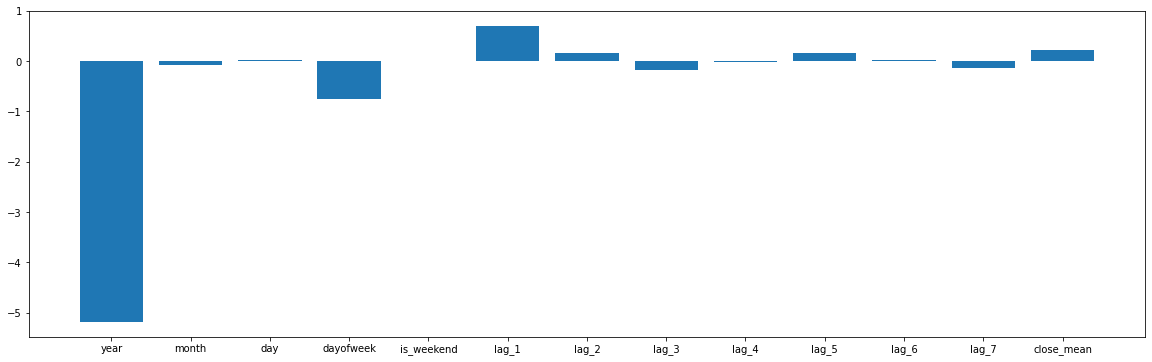

In [271]:
# plot feature importance
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
pyplot.bar([x for x in coefficients.feature], [y for y in coefficients.coef])
pyplot.show()

In [287]:
y_pred = model.predict(X_test)

In [294]:
print("RMSE тестовой выборки LinearRegression: ",round(np.sqrt(mean_squared_error(y_test, y_pred)),2))

RMSE тестовой выборки LinearRegression:  15.12


In [291]:
print(f"R2 коэффициент модели равен:  {round(model.score(X_test, y_test),2)}")

R2 коэффициент модели равен:  0.93


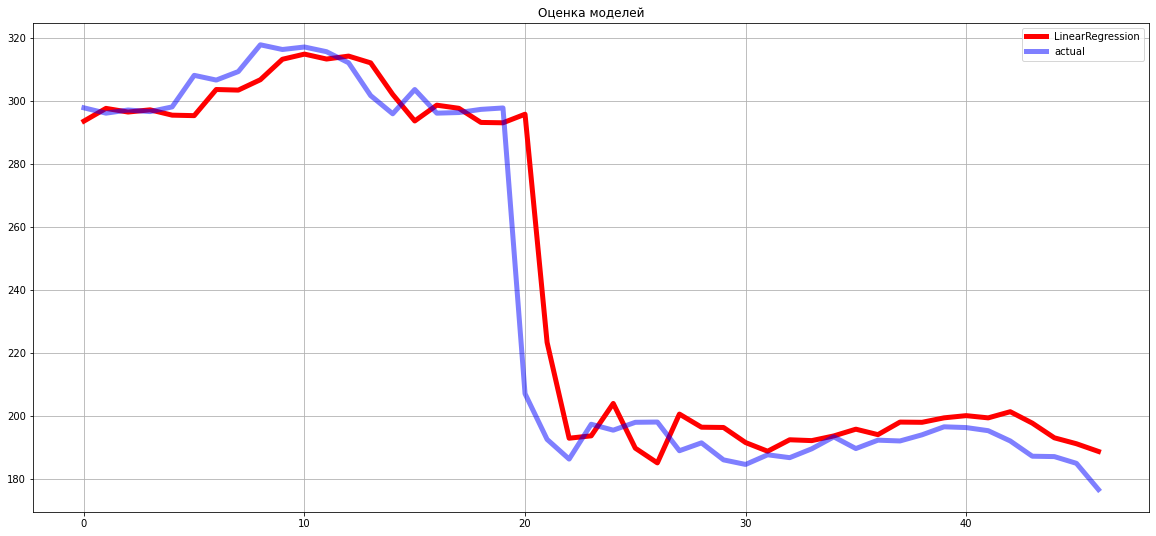

In [295]:
plt.figure(figsize=(20, 9))
plt.plot(y_pred, "r",linewidth=5, label="LinearRegression")
plt.plot(y_test.values,'b' ,label="actual", linewidth=5, alpha = 0.5)
plt.legend(loc="best")
plt.title("Оценка моделей")
plt.grid(True);

In [296]:
df_5Aug = df[df.index == datetime.strptime("2022/08/05", "%Y/%m/%d")]

df_6Aug = pd.DataFrame(0, index = [datetime.strptime("2022/08/06", "%Y/%m/%d")], columns = df.columns)
df_6Aug[['lag_1','lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']] = df_5Aug[['close', 'lag_1','lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']].values
df_6Aug['year'] = df_6Aug.index.year
df_6Aug['month'] = df_6Aug.index.month
df_6Aug['day'] = df_6Aug.index.day
df_6Aug['dayofweek'] = df_6Aug.index.dayofweek
df_6Aug['is_weekend'] = df_6Aug.index.isin([5,6])*1

dt_list = [datetime.strptime("2022/08/05", "%Y/%m/%d"), datetime.strptime("2022/08/04", "%Y/%m/%d"), datetime.strptime("2022/08/03", "%Y/%m/%d")]
df_6Aug['close_mean'] = df[df.index.isin(dt_list)].close.mean()

In [297]:
y = df_6Aug.drop("close", axis =1)
print (f"Предсказанная цена акции GAZP на 06.08.2022: {round(model.predict(y)[0],2)}")

Предсказанная цена акции GAZP на 06.08.2022: 180.54
